In [1]:
import os
import time
import random
import gzip

import gurobipy as gp
from gurobipy import GRB 
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# disable Gurobi output globally
gp.setParam("OutputFlag", 0)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-25


### Load Data

In [4]:
def getVarTypes(model):
    types = []
    for var in model.getVars():
        # classify as binary if integer with bounds [0, 1]
        if var.VType == GRB.INTEGER and var.LB == 0 and var.UB == 1:
            types.append(GRB.BINARY)
        else:
            types.append(var.VType)
    return types

def getObjVec(model):
    obj_vector = np.array([var.Obj for var in model.getVars()])
    return obj_vector

def getConstrMat(model):
    # init A
    num_constraints = model.NumConstrs
    num_variables = model.NumVars
    A_matrix = np.zeros((num_constraints, num_variables))
    # cnt
    i = 0
    for i, constraint in enumerate(model.getConstrs()):
        # check the sense and adjust if necessary
        if constraint.Sense == GRB.GREATER_EQUAL:
            # multiply the constraint row and RHS by -1 to convert >= to <=
            row = model.getRow(constraint)
            for j in range(row.size()):
                var = row.getVar(j)
                col_index = var.index
                A_matrix[i, col_index] = -row.getCoeff(j)
        elif constraint.Sense == GRB.LESS_EQUAL:
            # keep <= constraints as they are
            row = model.getRow(constraint)
            for j in range(row.size()):
                var = row.getVar(j)
                col_index = var.index
                A_matrix[i, col_index] = row.getCoeff(j)
        else:
            # raise an error if an equality constraint is encountered
            raise ValueError(f"Equality constraint found in constraint {constraint.ConstrName}. This is not allowed.")
        i += 1 
    return A_matrix

def getRhsVec(model):
    # init b
    num_constraints = model.NumConstrs
    num_variables = model.NumVars
    b_vector = np.zeros(num_constraints)
    for i, constraint in enumerate(model.getConstrs()):
        # check the sense and adjust if necessary
        if constraint.Sense == GRB.GREATER_EQUAL:
            b_vector[i] = -constraint.RHS
        elif constraint.Sense == GRB.LESS_EQUAL:
            # keep <= constraints as they are
            b_vector[i] = constraint.RHS
        else:
            # raise an error if an equality constraint is encountered
            raise ValueError(f"Equality constraint found in constraint {constraint.ConstrName}. This is not allowed.")   
    return b_vector

def getBounds(model):
    # lower bound
    lb_vector = np.array([var.LB for var in model.getVars()])
    # upper bound
    ub_vector = np.array([var.UB for var in model.getVars()])
    return lb_vector, ub_vector

In [5]:
# dir
data_dir = r".\data\datasets\vary_obj\series_1"
# init data
c_data = np.zeros((50, 360))
i = 0
# go through files
print("Obj vector for:")
for file_name in os.listdir(data_dir):
    if file_name.endswith(".mps.gz"):
        file_path = os.path.join(data_dir, file_name)
        # read file
        with gzip.open(file_path, "rb") as f:
            with open("temp.mps", "wb") as temp_file:
                temp_file.write(f.read())
        # load model
        model = gp.read("temp.mps")
        # print or process the RHS vector as needed
        obj_vector = getObjVec(model)
        c_data[i] = obj_vector
        # counting
        i += 1
print(c_data)

Obj vector for:
[[66. 57.  6. ... 33. 20. 37.]
 [66. 57.  6. ... 44. 80.  3.]
 [66. 57.  6. ... 83. 42. 77.]
 ...
 [66. 57.  6. ... 72. 89. 39.]
 [66. 57.  6. ... 14. 46. 16.]
 [66. 57.  6. ... 69. 21. 84.]]


In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(c_data, test_size=0.2, random_state=42)

In [7]:
# remove equality
#removeEquality(model)

# var type
types = getVarTypes(model)
# constraint
A = getConstrMat(model)
# rhs
b = getRhsVec(model)
# bound
lb, ub = getBounds(model)

In [8]:
# init
bin_ind = []
int_ind = []
for i, var_type in enumerate(types):
    # check if the variable is binary
    if var_type == GRB.BINARY:
        bin_ind.append(i)
     # check if the variable is integer
    elif var_type == GRB.INTEGER:
        int_ind.append(i)
print("Bin index:", bin_ind)
print("Int index:", int_ind)

Bin index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

### Analysis

In [9]:
# identify columns with all non-zero elements in b_data
non_zero_columns = np.all(train_data != 0, axis=0)
non_zero_column_indices = np.where(non_zero_columns)[0]  # Get the indices of columns with all non-zero elements
print("Indices of columns in c_data where all entries are non-zero:")
print("Nonzero cost:", len(non_zero_column_indices))
print(non_zero_column_indices)

Indices of columns in c_data where all entries are non-zero:
Nonzero cost: 360
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 

In [10]:
# find the maximum and minimum values for each column in b_data
train_data_col_max = np.max(train_data[:,non_zero_column_indices], axis=0)
train_data_col_min = np.min(train_data[:,non_zero_column_indices], axis=0)
different_ind = np.where(train_data_col_max != train_data_col_min)[0]
print(f"{len(different_ind)} Indices where maximum and minimum values are different:")
print(different_ind)

120 Indices where maximum and minimum values are different:
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359]


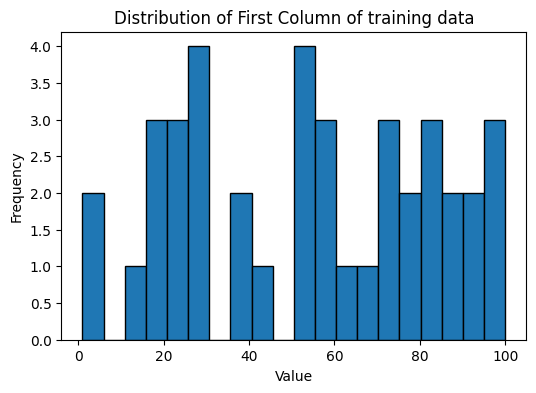

In [11]:
import matplotlib.pyplot as plt
# plot histogram for the a column
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, 240], bins=20, edgecolor='black')
plt.title("Distribution of First Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

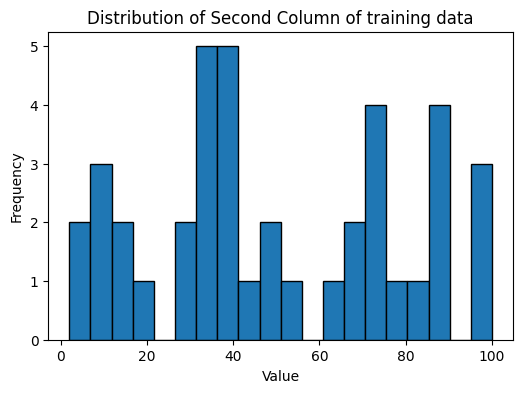

In [12]:
import matplotlib.pyplot as plt
# plot histogram for the a column of b_data
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, 241], bins=20, edgecolor='black')
plt.title("Distribution of Second Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

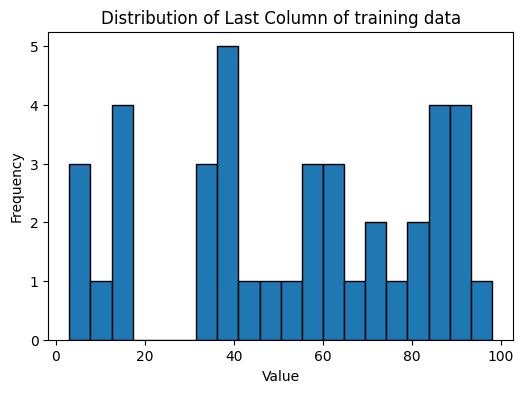

In [13]:
import matplotlib.pyplot as plt
# plot histogram for the a column of
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, -1], bins=20, edgecolor='black')
plt.title("Distribution of Last Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Generate Samples

In [14]:
# sample size
sample_size = 8000
# init sample
train_sample = np.zeros((sample_size, 120))
# get the column-wise max and min values from train_data
train_data_col_max = np.ceil(np.max(train_data[:,240:], axis=0)) + 5
train_data_col_min = np.floor(np.min(train_data[:,240:], axis=0)) - 5
# generate uniform random values for the first 250 rows between the min and max of each column
train_sample = np.random.randint(train_data_col_min, train_data_col_max, (sample_size, 120)).astype(float)
# display samples
print("Fixed part of c:")
c_fixed = train_data[0,:240]
print(c_fixed)
print("Sampled c_sample array:")
print(train_sample)

Fixed part of c:
[ 66.  57.   6.  74.  54.  65.  68.  86.  39.  23.   7.  24.  34.  48.
  63.  29.  81.  14.   8.  32.  13.  52.  40.  13.   3.  49.  97.  89.
  75.  82.   1.  61.  49.  67.  20.  72.  40.  55.   5.  13.  12.  38.
  97.  96.  70.  50.  78.  94.  17.  28.  44.  37.  56. 100.   1.  20.
  60.  27.   3.  14.  78.  70.  87.  16.  39.   2.  15.  97.  97.  49.
  13.  64.  10.  49.   4.  31.   6.  42.  14.  42.  18.  46.  51.  50.
  51.  46.   5.  27.  49.  71.  89.  66.  49.  55.   4.  33.  50.  17.
  79.  24.  68.  82.  94.  38.  21.  83.  22.  41.  14.  78.  14.  67.
  78.  26.  15.  36.  26.  52.  51.  97.  34.  54.   2.  95.   7.  49.
   7.  60.  98.  36.  33.  37.  83.  92.  20.  27.  40.  14.  27.  56.
  67.  45.  36.  71.  95.  79.  42.  59.  68.  24.  95.  19.  18.  45.
  37.  32.  50.  93.  17.  36.  90.  65.  88.  29.  73.  58.  90.  95.
  17.  76.   6.  72.  12.  56.   1.   5.  20.  24.  18.  35.  58.  26.
   2.  22.  36.  20. 100.   1.  39.  99.  92.  83.  97.  96.

### Baseline 

In [15]:
def setObj(model, c):
    # reset
    model.reset() 
    # update the obj
    for var, coeff in zip(model.getVars(), c):
        var.Obj = coeff
    # model update
    model.update()

In [16]:
def evaluateModel(model, x_val):
    # check if the number of variables matches the input values
    vars_in_model = model.getVars()
    if len(vars_in_model) != len(x_val):
        raise ValueError("The length of x_val does not match the number of model variables!")
    # calculate the objective function value
    objval = sum(var.Obj * val for var, val in zip(vars_in_model, x_val))
    # calculate constraint violations
    viols = []
    for constr in model.getConstrs():
        # Compute the left-hand side (lhs) value of the constraint
        lhs = sum(val * model.getCoeff(constr, var) for var, val in zip(vars_in_model, x_val))
        rhs = constr.rhs
        # determine the violation amount based on the constraint sense
        violation = max(0, lhs - rhs - 1e-6) if constr.sense == GRB.LESS_EQUAL else \
                    max(0, rhs - lhs - 1e-6) if constr.sense == GRB.GREATER_EQUAL else \
                    abs(lhs - rhs)
        # record the constraint name and its violation amount
        viols.append(violation)
    return objval, np.array(viols)

#### Exact Solver

In [17]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [18]:
# load model
model = gp.read("temp.mps")
# init df
params, sols, objvals, mean_viols, max_viols, num_viols, elapseds = [], [], [], [], [], [], []
for c in tqdm(test_data):
    # set rhs
    setObj(model, c)
    # solve
    tick = time.time()
    model.optimize()
    tock = time.time()
    # get solutions
    x_val = [var.x for var in model.getVars()]
    obj, viol = evaluateModel(model, x_val)
    # append to df
    params.append(list(c[non_zero_column_indices]))
    sols.append(x_val)
    objvals.append(model.objVal)
    mean_viols.append(np.mean(viol))
    max_viols.append(np.max(viol))
    num_viols.append(np.sum(viol > 1e-6))
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param": params,
                   "Sol": sols,
                   "Obj Val": objvals,
                   "Mean Violation": mean_viols,
                   "Max Violation": max_viols,
                   "Num Violations": num_viols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
df.to_csv("result/lp_exact_obj-series1.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:49<00:00, 28.95s/it]


           Obj Val  Mean Violation  Max Violation  Num Violations  \
count    10.000000            10.0           10.0            10.0   
mean   8756.800000             0.0            0.0             0.0   
std     162.387602             0.0            0.0             0.0   
min    8518.000000             0.0            0.0             0.0   
25%    8677.750000             0.0            0.0             0.0   
50%    8747.000000             0.0            0.0             0.0   
75%    8856.250000             0.0            0.0             0.0   
max    9073.000000             0.0            0.0             0.0   

       Elapsed Time  
count     10.000000  
mean      28.913145  
std       10.803956  
min       13.996350  
25%       20.177915  
50%       26.814653  
75%       38.238872  
max       44.846463  
Total elapsed time for optimization: 289.13 seconds


#### N1 Hueristic

In [19]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [20]:
# load model
model = gp.read("temp.mps")
# limit to root node
model.setParam("SolutionLimit", 1) 
# init df
params, sols, objvals, mean_viols, max_viols, num_viols, elapseds = [], [], [], [], [], [], []
for c in tqdm(test_data):
    # set rhs
    setObj(model, c)
    # solve
    tick = time.time()
    model.optimize()
    tock = time.time()
    # get solutions
    x_val = [var.x for var in model.getVars()]
    obj, viol = evaluateModel(model, x_val)
    # append to df
    params.append(list(c[non_zero_column_indices]))
    sols.append(x_val)
    objvals.append(model.objVal)
    mean_viols.append(np.mean(viol))
    max_viols.append(np.max(viol))
    num_viols.append(np.sum(viol > 1e-6))
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param": params,
                   "Sol": sols,
                   "Obj Val": objvals,
                   "Mean Violation": mean_viols,
                   "Max Violation": max_viols,
                   "Num Violations": num_viols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
df.to_csv("result/lp_root_obj-series1.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.49it/s]


            Obj Val  Mean Violation  Max Violation  Num Violations  \
count     10.000000            10.0           10.0            10.0   
mean   11901.100000             0.0            0.0             0.0   
std      221.315988             0.0            0.0             0.0   
min    11605.000000             0.0            0.0             0.0   
25%    11704.000000             0.0            0.0             0.0   
50%    11933.000000             0.0            0.0             0.0   
75%    12059.750000             0.0            0.0             0.0   
max    12247.000000             0.0            0.0             0.0   

       Elapsed Time  
count     10.000000  
mean       0.000888  
std        0.000496  
min        0.000000  
25%        0.000998  
50%        0.001006  
75%        0.001045  
max        0.001509  
Total elapsed time for optimization: 0.01 seconds


### Learning-to-Optimize

In [21]:
# hpyerparameters
batch_size = 64
hlayers_sol = 5
hlayers_rnd = 4
hsize = 256
lr = 1e-3
penalty_weight = 100

In [22]:
from torch.utils.data import DataLoader
from neuromancer.dataset import DictDataset
# get dataset
data_train = DictDataset({"c":torch.from_numpy(train_sample).float()}, name="train")
data_val = DictDataset({"c":torch.from_numpy(train_data[:,240:]).float()}, name="train")
# set dataloader
loader_train = DataLoader(data_train, batch_size, num_workers=0,
                          collate_fn=data_train.collate_fn, shuffle=True)
loader_val   = DataLoader(data_val, batch_size, num_workers=0,
                          collate_fn=data_train.collate_fn, shuffle=True)

In [23]:
class penaltyLoss(nn.Module):
    """
    Penalty loss function for linear optimization problems.
    """
    def __init__(self, input_keys, c_fixed, A, b, lb, ub, penalty_weight=50, output_key="loss"):
        """
        Initialize penalty loss with problem parameters.
        """
        super().__init__()
        self.c_key, self.x_key = input_keys
        self.output_key = output_key
        self.penalty_weight = penalty_weight
        self.device = None
        # fixed coefficients
        self.c_fixed = torch.from_numpy(c_fixed).float()
        self.A = torch.from_numpy(A).float()
        self.b = torch.from_numpy(b).float()
        self.lb = torch.from_numpy(lb).float()
        self.ub = torch.from_numpy(ub).float()

    def forward(self, input_dict):
        """
        Forward pass to compute the penalty loss.
        """
        # objective function calculation
        obj_value = self.cal_obj(input_dict)
        # constraint violation calculation
        viol_value = self.cal_constr_viol(input_dict)
        # penalized loss
        loss = obj_value + self.penalty_weight * viol_value
        # mean loss
        input_dict[self.output_key] = torch.mean(loss)
        return input_dict

    def cal_obj(self, input_dict):
        """
        Calculate the linear objective function.
        """
        c, x = input_dict[self.c_key], input_dict[self.x_key]
        # move parameters to the correct device if not already set
        if self.device is None:
            self.device = x.device
            self.c_fixed = self.c_fixed.to(self.device)
            self.A = self.A.to(self.device)
            self.b = self.b.to(self.device)
            self.lb = self.lb.to(self.device)
            self.ub = self.ub.to(self.device)
        # concatenate along the feature dimension (dim=1)
        c = torch.cat((self.c_fixed.repeat(c.size(0), 1), c), dim=1)
        # calculate c^T x for the objective
        obj_term = torch.einsum("bn,bn->b", c, x)
        return obj_term

    def cal_constr_viol(self, input_dict):
        """
        Calculate constraint and bounds violations.
        """
        x = input_dict[self.x_key]
        # calculate constraint violations (Ax <= b)
        lhs = torch.einsum("mn,bn->bm", self.A, x)  # Ax
        constr_violation = torch.relu(lhs - self.b).sum(dim=1)  # Max(0, Ax - b)
        # calculate bounds violations
        lower_violation = torch.relu(self.lb - x).sum(dim=1)  # x >= lb
        upper_violation = torch.relu(x - self.ub).sum(dim=1)  # x <= ub
        return constr_violation + lower_violation + upper_violation

#### Rounding Classification

In [24]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [25]:
import neuromancer as nm
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=120, outsize=model.NumVars, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["c"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=120+model.NumVars,
                   hidden_dims=[hsize]*hlayers_rnd,
                   output_dim=model.NumVars)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["c"], var_keys=["x"],
                       output_keys=["x_rnd"], bin_ind={"x":bin_ind},
                       continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = penaltyLoss(["c", "x_rnd"], c_fixed, A, b, lb, ub, penalty_weight)

In [26]:
from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_val)

Epoch 0, Iters 0, Validation Loss: 14922675.00
Epoch 0, Iters 125, Training Loss: 10476915.41, Validation Loss: 16859.22
Epoch 1, Iters 250, Training Loss: 61861.72, Validation Loss: 15145.60
Epoch 2, Iters 375, Training Loss: 18997.83, Validation Loss: 12694.80
Epoch 3, Iters 500, Training Loss: 13913.09, Validation Loss: 11566.73
Epoch 4, Iters 625, Training Loss: 11652.16, Validation Loss: 10933.33
Epoch 5, Iters 750, Training Loss: 11542.65, Validation Loss: 10388.33
Epoch 6, Iters 875, Training Loss: 10791.96, Validation Loss: 10486.23
Epoch 7, Iters 1000, Training Loss: 10865.89, Validation Loss: 10353.78
Epoch 8, Iters 1125, Training Loss: 10440.87, Validation Loss: 10147.90
Epoch 9, Iters 1250, Training Loss: 10280.30, Validation Loss: 10042.35
Epoch 10, Iters 1375, Training Loss: 10365.33, Validation Loss: 3520872.75
Epoch 11, Iters 1500, Training Loss: 10246.44, Validation Loss: 9950.08
Epoch 12, Iters 1625, Training Loss: 10131.33, Validation Loss: 9937.55
Epoch 13, Iters 17

In [27]:
# init df
params, sols, objvals, mean_viols, max_viols, num_viols, elapseds = [], [], [], [], [], [], []
for c in tqdm(test_data):
    # set coefs
    setObj(model, c)
    # data point as tensor
    datapoints = {"c": torch.unsqueeze(torch.tensor(c[240:]).float(), 0).to("cuda"),
                  "name": "test"}
    # infer
    components.eval()
    tick = time.time()
    with torch.no_grad():
        for comp in components:
            datapoints.update(comp(datapoints))
    tock = time.time()
    # get solutions
    x_val = datapoints["x_rnd"][0].detach().cpu().numpy()
    obj, viol = evaluateModel(model, x_val)
    # append to df
    params.append(list(c[non_zero_column_indices]))
    sols.append(list(x_val))
    objvals.append(obj)
    mean_viols.append(np.mean(viol))
    max_viols.append(np.max(viol))
    num_viols.append(np.sum(viol > 1e-6))
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param": params,
                   "Sol": sols,
                   "Obj Val": objvals,
                   "Mean Violation": mean_viols,
                   "Max Violation": max_viols,
                   "Num Violations": num_viols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
print("Number of infeasible solution: {}".format(np.sum(df["Num Violations"] > 0)))
df.to_csv("result/lp_cls_obj-series1.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.46it/s]


           Obj Val  Mean Violation  Max Violation  Num Violations  \
count    10.000000            10.0           10.0            10.0   
mean   9745.900000             0.0            0.0             0.0   
std     163.528761             0.0            0.0             0.0   
min    9445.000000             0.0            0.0             0.0   
25%    9645.000000             0.0            0.0             0.0   
50%    9763.000000             0.0            0.0             0.0   
75%    9815.500000             0.0            0.0             0.0   
max    9979.000000             0.0            0.0             0.0   

       Elapsed Time  
count     10.000000  
mean       0.004242  
std        0.002297  
min        0.002001  
25%        0.003009  
50%        0.003579  
75%        0.004338  
max        0.010159  
Total elapsed time for optimization: 0.04 seconds
Number of infeasible solution: 0


#### Learnable Threshold

In [28]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [29]:
import neuromancer as nm
from src.func.layer import netFC
from src.func import roundThresholdModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=120, outsize=model.NumVars, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["c"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=120+model.NumVars,
                   hidden_dims=[hsize]*hlayers_rnd,
                   output_dim=model.NumVars)
rnd = roundThresholdModel(layers=layers_rnd, param_keys=["c"], var_keys=["x"],
                          output_keys=["x_rnd"], bin_ind={"x":bin_ind},
                          continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = penaltyLoss(["c", "x_rnd"], c_fixed, A, b, lb, ub, penalty_weight)

In [30]:
from src.problem.neuromancer.trainer import trainer
# training
epochs = 20                     # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_val)

Epoch 0, Iters 0, Validation Loss: 43507836.00
Epoch 0, Iters 125, Training Loss: 602057.59, Validation Loss: 13894.48
Epoch 1, Iters 250, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 2, Iters 375, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 3, Iters 500, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 4, Iters 625, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 5, Iters 750, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 6, Iters 875, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 7, Iters 1000, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 8, Iters 1125, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 9, Iters 1250, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 10, Iters 1375, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 11, Iters 1500, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 12, Iters 1625, Training Loss: 13909.44, Validation Loss: 13894.48
Epoch 13, Iters 1750

In [31]:
# init df
params, sols, objvals, mean_viols, max_viols, num_viols, elapseds = [], [], [], [], [], [], []
for c in tqdm(test_data):
    # data point as tensor
    datapoints = {"c": torch.unsqueeze(torch.tensor(c[240:]).float(), 0).to("cuda"),
                  "name": "test"}
    # infer
    components.eval()
    tick = time.time()
    with torch.no_grad():
        for comp in components:
            datapoints.update(comp(datapoints))
    tock = time.time()
    # get solutions
    x_val = datapoints["x_rnd"][0].detach().cpu().numpy()
    obj, viol = evaluateModel(model, x_val)
    # append to df
    params.append(list(c[non_zero_column_indices]))
    sols.append(list(x_val))
    objvals.append(obj)
    mean_viols.append(np.mean(viol))
    max_viols.append(np.max(viol))
    num_viols.append(np.sum(viol > 1e-6))
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param": params,
                   "Sol": sols,
                   "Obj Val": objvals,
                   "Mean Violation": mean_viols,
                   "Max Violation": max_viols,
                   "Num Violations": num_viols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
print("Number of infeasible solution: {}".format(np.sum(df["Num Violations"] > 0)))
df.to_csv("result/lp_thd_obj-series1.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.58it/s]


       Obj Val  Mean Violation  Max Violation  Num Violations  Elapsed Time
count     10.0            10.0           10.0            10.0     10.000000
mean   14149.0             0.0            0.0             0.0      0.003597
std        0.0             0.0            0.0             0.0      0.000876
min    14149.0             0.0            0.0             0.0      0.002001
25%    14149.0             0.0            0.0             0.0      0.003019
50%    14149.0             0.0            0.0             0.0      0.003524
75%    14149.0             0.0            0.0             0.0      0.004372
max    14149.0             0.0            0.0             0.0      0.004841
Total elapsed time for optimization: 0.04 seconds
Number of infeasible solution: 0
